In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch.nn as nn
import cv2
import torchvision.transforms as T
from torchinfo import summary
from torch.optim import Adam

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
notebook_dir= os.path.dirname(os.path.abspath("__file__"))
project_root= os.path.abspath(os.path.join(notebook_dir, '..'))

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import data_dir, images_train_dir, images_val_dir, labels_train_dir, labels_val_dir, artifacts_dir
import config
from preprocessing import FaceDataset, generate_anchor_boxes, match_anchors_to_gt, filter_valid_bboxes, calculate_iou
from utils import draw_image_with_box, visualize_anchors_and_gt

In [3]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_train_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]

['998faa48943fce6f.jpg',
 'a228f997057aa291.jpg',
 '49fe432784afea63.jpg',
 '0106e273d2de08be.jpg']

In [4]:
train_images, val_images= train_test_split(all_images, test_size= 0.2, random_state= 42)
transforms= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Normalize(mean=(0.5,) * 3, std=(0.5,) * 3)
])
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, max_boxes= 10, transform= transforms)
train_dataset[1]

{'image': tensor([[[352.0565, 352.8867, 360.1703,  ..., 310.4937, 312.1322, 317.5887],
          [357.4591, 350.7386, 352.0140,  ..., 307.6113, 307.7637, 313.3150],
          [359.0363, 354.8296, 360.0101,  ..., 317.0617, 310.3904, 312.4282],
          ...,
          [411.6109, 419.3404, 419.9554,  ..., 363.2943, 383.0967, 392.4502],
          [403.0862, 413.5461, 417.4562,  ..., 369.6827, 379.9071, 397.3633],
          [402.7126, 408.7515, 421.1537,  ..., 377.0258, 384.0236, 395.4594]],
 
         [[338.8630, 336.8812, 345.0944,  ..., 309.1349, 305.6900, 306.6149],
          [339.3872, 338.4984, 340.5155,  ..., 305.9809, 305.2375, 306.2781],
          [339.8438, 336.8338, 337.3852,  ..., 303.9751, 301.6772, 303.6800],
          ...,
          [442.3775, 445.9425, 443.2556,  ..., 378.2266, 396.6841, 411.5230],
          [425.7448, 433.5830, 441.4240,  ..., 382.3954, 403.6296, 417.9796],
          [424.5801, 433.7004, 450.4931,  ..., 389.6900, 411.0536, 424.5646]],
 
         [[214.8292

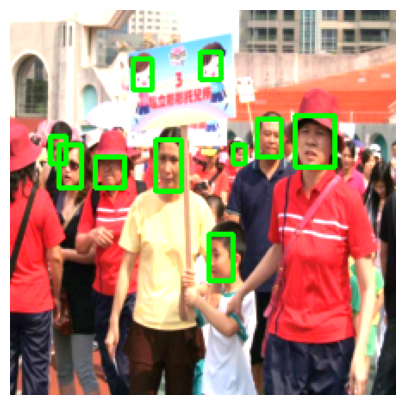

In [5]:
draw_image_with_box(train_dataset[2]['image'], train_dataset[2]['boxes'])

In [6]:
vgg16_backbone= models.vgg16(weights= models.VGG16_Weights.IMAGENET1K_V1)
features_extractor= vgg16_backbone.features

In [7]:
print(features_extractor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [8]:
last_pool_idx= -1
for i, layer in enumerate(features_extractor):
    if isinstance(layer, nn.MaxPool2d):
        last_pool_idx= i
if last_pool_idx != -1:
    backbone_layers= list(features_extractor.children())[:last_pool_idx-1]
    vgg16_conv_features= nn.Sequential(*backbone_layers)
else:
    print('Unexpected structure taking all features from backbone')
    vgg16_conv_features= features_extractor
num_out_channels_backbone= vgg16_conv_features[-1].out_channels
vgg16_conv_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
torch.save(vgg16_conv_features, artifacts_dir + "vgg16_backbone_feat_ext.pth")

In [10]:
vgg16_conv_features= torch.load(artifacts_dir + "vgg16_backbone_feat_ext.pth")

In [11]:
image_sample= train_dataset[0]['image']
ff_output= vgg16_conv_features(image_sample)

In [12]:
image_sample.shape

torch.Size([3, 224, 224])

In [13]:
ff_output.shape

torch.Size([512, 14, 14])

In [14]:
feature_map_shape = (14, 14) # Output shape from VGG16 with 256x256 input
image_shape_resized = (224, 224) # The size your image is resized to for the model
stride = image_shape_resized[0] / feature_map_shape[0] # Stride based on RESIZED image (256 / 16 = 16)

anchor_scales = [8, 16, 24, 32, 64, 128] # Scales in pixels relative to the RESIZED image (256x256)
anchor_ratios = [0.5, 0.75, 1.0, 1.33, 2.0]

# Generate anchors using the RESIZED image shape and calculated stride
all_anchors = generate_anchor_boxes(
    feature_map_shape,
    image_shape_resized, # Use RESIZED image shape here!
    anchor_scales,
    anchor_ratios,
    stride
)
print(f"Feature map shape: {feature_map_shape}")
print(f"Resized image shape: {image_shape_resized}")
print(f"Stride: {stride}")
print(f"Scales: {anchor_scales}, Ratios: {anchor_ratios}")
print(f"Generated {all_anchors.shape[0]} anchors. Shape: {all_anchors.shape}")
print("First 5 anchors:\n", all_anchors[:5])

Feature map shape: (14, 14)
Resized image shape: (224, 224)
Stride: 16.0
Scales: [8, 16, 24, 32, 64, 128], Ratios: [0.5, 0.75, 1.0, 1.33, 2.0]
Generated 5880 anchors. Shape: torch.Size([5880, 4])
First 5 anchors:
 tensor([[0.0231, 0.0105, 0.0483, 0.0610],
        [0.0202, 0.0151, 0.0512, 0.0563],
        [0.0179, 0.0179, 0.0536, 0.0536],
        [0.0151, 0.0202, 0.0563, 0.0512],
        [0.0105, 0.0231, 0.0610, 0.0483]])


In [15]:
all_anchors

tensor([[0.0231, 0.0105, 0.0483, 0.0610],
        [0.0202, 0.0151, 0.0512, 0.0563],
        [0.0179, 0.0179, 0.0536, 0.0536],
        ...,
        [0.6786, 0.6786, 0.9955, 0.9955],
        [0.6348, 0.7165, 0.9955, 0.9955],
        [0.5602, 0.7623, 0.9955, 0.9955]])

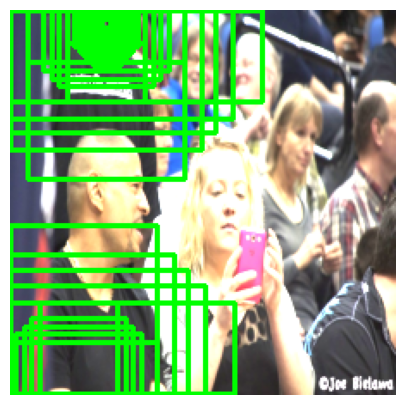

In [16]:
sample_image= train_dataset[8]['image']
sample_label= train_dataset[8]['boxes']

np_image_display= sample_image.detach().cpu().numpy()
np_image_display = np.transpose(np_image_display, (1, 2, 0)) # CxHxW to HxWxC

# Normalize to [0, 255] uint8
if np_image_display.max() <= 1.0:
    np_image_display = (np_image_display * 255).astype(np.uint8)
else:
    np_image_display = np_image_display.astype(np.uint8)

# Ensure contiguous
if not np_image_display.flags['C_CONTIGUOUS']:
    np_image_display = np.ascontiguousarray(np_image_display)

# Draw ALL anchors on the resized image
draw_image_with_box(sample_image, all_anchors[1250:1300])

In [17]:
filtered_bboxes= filter_valid_bboxes(sample_label)
iou= calculate_iou(all_anchors, filtered_bboxes)
all_anchors.shape, iou.shape, filtered_bboxes.shape

(torch.Size([5880, 4]), torch.Size([5880, 7]), torch.Size([7, 4]))

In [18]:
iou.max()

tensor(0.6896)

In [19]:
matched_targs= match_anchors_to_gt(all_anchors, sample_label)
matched_labels, regression_targets= matched_targs['labels'], matched_targs['regression_targets']
num_positive_labels= torch.sum(matched_labels==1)
num_positive_labels

tensor(13)

In [20]:
torch.where(matched_labels==1)[0]

tensor([1875, 2225, 2596, 3135, 3430, 3431, 3432, 3435, 4330, 4331, 4332, 4335,
        5590])

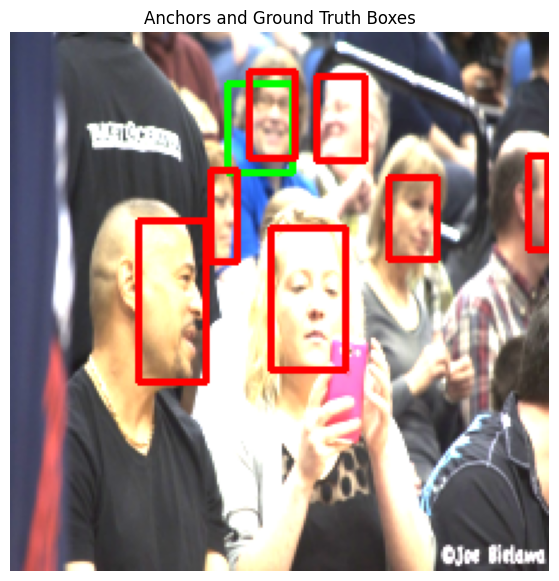

In [21]:
visualize_anchors_and_gt(sample_image, all_anchors[2596:2597], filtered_bboxes)

In [22]:
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors_per_location= 30):
        super(RPN, self).__init__()
        self.num_anchors= num_anchors_per_location
        self.in_channels= in_channels

        self.shared_conv= nn.Conv2d(in_channels, 512, kernel_size= 3, stride= 1, padding= 1)
        self.relu= nn.ReLU(inplace= True)

        self.cls_layer= nn.Conv2d(512, self.num_anchors * 1, kernel_size= 1,
                                  stride= 1, padding= 0)
        
        self.reg_layer= nn.Conv2d(512, self.num_anchors * 4, kernel_size= 1,
                                  stride= 1, padding= 0)
    
    def forward(self, x):
        # Apply shared conv to get features of region proposal
        shared_feats= self.relu(self.shared_conv(x))
        # Get classification scores
        cls_scores= self.cls_layer(shared_feats)
        # Get reg deltas
        reg_deltas= self.reg_layer(shared_feats)

        cls_scores= cls_scores.view(x.size(0), self.num_anchors, -1,
                                    x.size(2), x.size(3))
        reg_deltas= reg_deltas.view(x.size(0), self.num_anchors, -1,
                                    x.size(2), x.size(3))
        return {
            'cls_scores': cls_scores,
            'reg_deltas': reg_deltas
        }

In [23]:
def rpn_loss_fn(cls_scores, reg_deltas, anchor_labels, regression_targets, device= 'cpu'):
    cls_scores= cls_scores.view(-1)
    anchor_labels= anchor_labels.view(-1)

    # Filtering ignopred anchors (-1)
    valid_mask= anchor_labels >= 0
    cls_scores_valid= cls_scores[valid_mask]
    anchor_labels_valid= anchor_labels[valid_mask]
    anchor_labels_valid= anchor_labels_valid.float().to(device)
    bce_loss= nn.BCEWithLogitsLoss()
    objectness_loss= bce_loss(cls_scores_valid, anchor_labels_valid)

    reg_deltas= reg_deltas.view(-1, 4)
    regression_targets= regression_targets.view(-1, 4)

    positive_mask= anchor_labels == 1
    reg_deltas_positive= reg_deltas[positive_mask]
    regression_targets_positive= regression_targets[positive_mask]
    
    smooth_l1_loss= nn.SmoothL1Loss()
    if reg_deltas_positive.numel() > 0:
        regression_loss= smooth_l1_loss(reg_deltas_positive, regression_targets_positive)
    else:
        regression_loss= torch.tensor(0.0, device= reg_deltas.device)
    
    lambda_reg= 10.0
    total_loss= objectness_loss + lambda_reg * regression_loss
    return {
        'objectness_loss': objectness_loss,
        'regression_loss': regression_loss,
        'total_loss': total_loss
    }


In [24]:
len(all_images[:700])

700

In [25]:
train_images, validation_images= train_test_split(all_images[:4000], test_size= 0.2, random_state= 42)
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, max_boxes= 10, transform= transforms)
val_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= validation_images, max_boxes= 10, transform= transforms)
len(val_dataset)

800

In [26]:
train_loader= DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= config.BATCH_SIZE, shuffle= False)

In [27]:
# device= 'cuda' if torch.cuda.is_available() else 'cpu'
# rpn.to(device)

In [28]:
# batch= next(iter(train_loader))
# images= batch['image']
# images= vgg16_conv_features(images)
# images= images.to(device)
# labels= batch['boxes']
# summary(rpn, input_data= images)

In [29]:
with torch.no_grad():
    feature_maps= vgg16_conv_features(sample_image)
rpn_model = RPN(in_channels= 512)
summary(rpn_model, input_size= (16, 512, 14, 14))

Layer (type:depth-idx)                   Output Shape              Param #
RPN                                      [16, 30, 4, 14, 14]       --
├─Conv2d: 1-1                            [16, 512, 14, 14]         2,359,808
├─ReLU: 1-2                              [16, 512, 14, 14]         --
├─Conv2d: 1-3                            [16, 30, 14, 14]          15,390
├─Conv2d: 1-4                            [16, 120, 14, 14]         61,560
Total params: 2,436,758
Trainable params: 2,436,758
Non-trainable params: 0
Total mult-adds (G): 7.64
Input size (MB): 6.42
Forward/backward pass size (MB): 16.61
Params size (MB): 9.75
Estimated Total Size (MB): 32.78

In [ ]:
optimizer= Adam(rpn_model.parameters(), lr= config.LEARNING_RATE)
train_loss_history= []
val_loss_history= []
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rpn_model.to(device)
vgg16_conv_features.to(device)
for epoch in range(config.EPOCHS):
    epoch_loss= 0.0
    rpn_model.train()

    for batch in train_loader:
        images= batch['image'].to(device)
        gt_boxes= batch['boxes'].to(device)

        with torch.no_grad():
            feature_maps= vgg16_conv_features(images)
        all_anchors= generate_anchor_boxes(
            feature_map_shape= feature_maps.shape[2:4],
            image_shape= images.shape[2:4],
            scales= config.ANCHOR_SCALES,
            ratios= config.ANCHOR_RATIOS,
            stride= config.ANCHOR_STRIDE
        ).to(device)

        rpn_outputs= rpn_model(feature_maps)
        cls_scores= rpn_outputs['cls_scores']
        reg_deltas= rpn_outputs['reg_deltas']

        batch_loss= 0.0
        for i in range(images.size(0)):
            anchor_labels_and_targs= match_anchors_to_gt(
                anchor_boxes= all_anchors,
                gt_boxes= gt_boxes[i],
                iou_high_threshold= config.IOU_HIGH_THRESHOLD,
                iou_low_threshold= config.IOU_LOW_THRESHOLD,
                device= device
            )
            anchor_labels= anchor_labels_and_targs['labels']
            regression_targets= anchor_labels_and_targs['regression_targets']
            losses= rpn_loss_fn(cls_scores[i], reg_deltas[i], anchor_labels, regression_targets, device= device)
            batch_loss += losses['total_loss']

        batch_loss /= images.size(0)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    epoch_loss += batch_loss.item()
    epoch_loss /= len(train_loader)
    train_loss_history.append(epoch_loss)
    print(f"Epoch: {epoch + 1}/{config.EPOCHS} | Train Loss: {epoch_loss:.4f}")

    rpn_model.eval()
    epoch_val_loss= 0.0
    with torch.no_grad():
        for batch in val_loader:
            images= batch['image'].to(device)
            gt_boxes= batch['boxes'].to(device)

            feature_maps= vgg16_conv_features(images)
            all_anchors= generate_anchor_boxes(
                feature_map_shape= feature_maps.shape[2:4],
                image_shape= images.shape[2:4],
                scales= config.ANCHOR_SCALES,
                ratios= config.ANCHOR_RATIOS,
                stride= config.ANCHOR_STRIDE
            ).to(device)

            rpn_outputs= rpn_model(feature_maps)
            cls_scores= rpn_outputs['cls_scores']
            reg_deltas= rpn_outputs['reg_deltas']

            batch_loss= 0.0
            for i in range(images.size(0)):
                anchor_labels_and_targs= match_anchors_to_gt(
                    anchor_boxes= all_anchors,
                    gt_boxes= gt_boxes[i],
                    iou_high_threshold= config.IOU_HIGH_THRESHOLD,
                    iou_low_threshold= config.IOU_LOW_THRESHOLD,
                    device= device
                )
                anchor_labels= anchor_labels_and_targs['labels']
                regression_targets= anchor_labels_and_targs['regression_targets']
                losses= rpn_loss_fn(
                    cls_scores[i], reg_deltas[i], anchor_labels, regression_targets,
                    device= device
                )
                batch_loss += losses['total_loss']
            r
        batch_loss /= images.size(0)
        epoch_val_loss += batch_loss.item()
        epoch_val_loss /= len(val_loader)
        val_loss_history.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}/{config.EPOCHS}, Validation Loss: {epoch_val_loss:.4f}")

Epoch: 1/3 | Train Loss: 0.0044
Epoch 1/3, Validation Loss: 0.0204
Epoch: 2/3 | Train Loss: 0.0059
Epoch 2/3, Validation Loss: 0.0187
Epoch: 3/3 | Train Loss: 0.0045
Epoch 3/3, Validation Loss: 0.0173


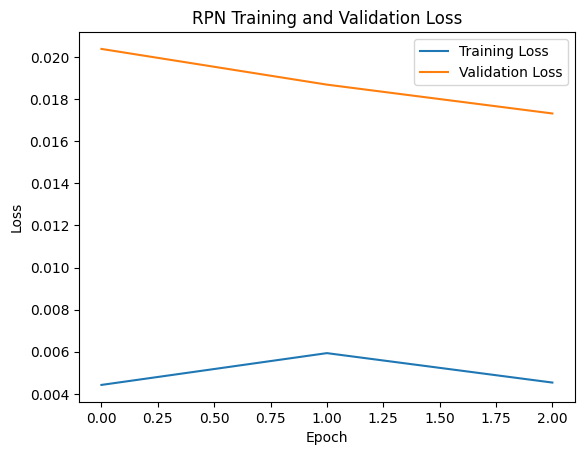

In [31]:
plt.plot(train_loss_history, label= "Training Loss")
plt.plot(val_loss_history, label= "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RPN Training and Validation Loss")
plt.legend()
plt.show()